## Import Library

In [1]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.crs import CRS
from rasterio.warp import transform_geom
from pyproj import Transformer
from shapely.geometry import Polygon
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import glob
import folium
from scipy.stats import norm, gamma, f, chi2


## Functions
#### - det
#### - getvv
#### - clip_img
#### - match
#### - rgb_composite
#### - folium_transform
#### - omnibus
#### - interpolate_nan
#### - sample_vv_imgs

In [2]:

def det(img):
    """Calculates VV*VH"""
    return np.multiply(img['band_data']['vv_band'], img['band_data']['vh_band'])


def getvv(im_list):
    'VV band only in band_data'
    vv = []
    for img in im_list:
        raster_data = {
            'band_data': {'vv_band': img['band_data']['vv_band']}, 
            'angle': img['angle'],
            'meta': img['meta'],
            'bounds': img['bounds'],
            'name': img['name']
        }
        vv.append(raster_data)
    return vv


def clip_img(fp, aoi_sub, src_crs = 4326, dst_crs = 32652):
    """
    Clips a list of images into aoi_sub
    fp : file path
    aoi_sub: default(dict type / EPSG:4326 / 'key': 'coordinates', 'type'='Poyligon')
    """
    crs1 = CRS.from_epsg(src_crs)   # Source CRS
    crs2 = CRS.from_epsg(dst_crs)   # Target CRS 
    aoi_sub = transform_geom(crs1, crs2, aoi_sub)
    bbox = Polygon(aoi_sub['coordinates'][0]).bounds

    im_list_clip = []
    for file in fp:
        with rasterio.open(file) as src:
            clip, out_transform = mask(src, [aoi_sub], crop=True, indexes=[1,2])
            clip[0] = np.where(clip[0]==0, np.nan, clip[0])
            clip[1] = np.where(clip[1]==0, np.nan, clip[1])

            raster_data = {'band_data': {'vv_band': clip[0],
                                         'vh_band': clip[1]},
                            # read(1) : VV | read(2): VH | read(3): Angle
                            'angle': src.read(3), 
                            'meta': {'driver': src.meta['driver'],
                                      'dtype': src.meta['dtype'],
                                     'nodata': {'vv_band': np.sum(np.isnan(clip[0])),
                                                'vh_band': np.sum(np.isnan(clip[1]))},
                                      'width': clip[0].shape[1],
                                     'height': clip[0].shape[0],
                                      'count': 3,
                                        'crs': src.meta['crs'],
                                  'transform': out_transform},
                            'bounds': bbox,
                            'name': src.name.split('/')[-1].split('.')[0]}
            im_list_clip.append(raster_data)
    return im_list_clip


def match(im_list):
    '''Match shape of arrays in im_list[i]['band_data']['vv_band]'''
    for band in im_list[0]['band_data'].keys():
        min_rows, min_cols = im_list[0]['band_data'][band].shape[0], im_list[0]['band_data'][band].shape[1]

        for j in range(len(im_list)):
            if im_list[j]['band_data'][band].shape[0] < min_rows:
                min_rows = im_list[j]['band_data'][band].shape[0]

            if im_list[j]['band_data'][band].shape[1] < min_cols:
                min_cols = im_list[j]['band_data'][band].shape[1]

        for j in range(len(im_list)):
            im_list[j]['band_data'][band] = im_list[j]['band_data'][band][:min_rows, :min_cols]

    return im_list


def rgb_compostite(im_list, index, clip_range, band=1):
    '''Stack 3 bands'''
    if band == 1:
        '''VV band'''
        rgb_image = np.stack((im_list[index[0]]['band_data']['vv_band'],
                              im_list[index[1]]['band_data']['vv_band'],
                              im_list[index[2]]['band_data']['vv_band']), axis = -1)
    elif band == 2:
        '''VH band'''
        rgb_image = np.stack((im_list[index[0]]['band_data']['vh_band'],
                              im_list[index[1]]['band_data']['vh_band'],
                              im_list[index[2]]['band_data']['vh_band']), axis = -1)
    for i in range(rgb_image.shape[-1]):
        rgb_image[:, :, i] = interpolate_nan(rgb_image[:, :, i])
    
    rgb_image = 10*np.log10(rgb_image) # to decibels
    rgb_image = np.clip(rgb_image, clip_range[0], clip_range[1])
    rgb_image = (rgb_image + 20) / 20
    return rgb_image


def folium_transform(im_list):
    '''
    returns Bounds and Location in EPSG:4326
    More accurately, use coordinates from geoJSON.
    Can be slightly changed when tranforming crs
    '''
    transformer = Transformer.from_crs(im_list[0]['meta']['crs'], 'EPSG:4326')

    minx, miny = im_list[0]['bounds'][0], im_list[0]['bounds'][1]
    maxx, maxy = im_list[0]['bounds'][2], im_list[0]['bounds'][3]
    for i in range(len(vv_list)):
        if im_list[i]['bounds'][0] < minx:
            minx = im_list[i]['bounds'][0]
    
        if im_list[i]['bounds'][1] < miny:
            miny = im_list[i]['bounds'][1]
    
        if im_list[i]['bounds'][2] > maxx:
            maxx = im_list[i]['bounds'][2]
    
        if im_list[i]['bounds'][3] > maxy:
            maxy = im_list[i]['bounds'][3]

    minx, miny = transformer.transform( minx,
                                        miny)
    maxx, maxy = transformer.transform( maxx,
                                        maxy)

    bounds = [[minx,  miny],
              [maxx,  maxy]]

    location = [(miny + maxy) / 2,
                (minx + maxx) / 2][::-1]
    return bounds, location


def omnibus(im_list, m=4.4):
    """Calculates the omnibus test statistic, monovariate(vv) case."""
    def log(current):
        return np.log(current)
    
    img = []
    k = len(im_list)
    klogk = k*np.log(k)

    for i in range(0,k):
        img.append(im_list[i]['band_data']['vv_band'])

    sumlogs = np.sum([log(i) for i in img], axis=0)
    logsum = np.log(np.sum(img, axis=0)) * k
    return (klogk + sumlogs - logsum) * (-2 * m)


def interpolate_nan(array):
    """Replace NaN values in the array with the interpolation."""
    x, y = np.meshgrid(np.arange(array.shape[1]), np.arange(array.shape[0]))
    valid_points = ~np.isnan(array)
    coords_valid = np.array((x[valid_points], y[valid_points])).T
    values_valid = array[valid_points]

    coords_all = np.array((x.flatten(), y.flatten())).T

    arr = griddata(coords_valid, values_valid, coords_all, method='nearest').reshape(array.shape)
    return arr


def sample_vv_imgs(j, im_list):
    """Samples the test statistics Rj """

    vv_list = [img['band_data']['vv_band'] for img in im_list]
    sj = vv_list[j - 1]
    jfact = (j ** j) / (j-1) ** (j-1)
    sumj = np.sum(vv_list[:j], axis=0)
    sumjm1 = np.sum(vv_list[:j-1], axis=0)
    Rj = (((sumjm1 ** (j-1)) * sj * jfact) / ((sumj ** j))) ** 5

    sample = Rj.flatten()
    np.random.seed(123)
    sample = np.random.choice(sample, size=1000)
    return sample


## Create Image List

In [3]:

fp = glob.glob(r'/Users/hoyeong/Documents/PYTHON/ChangeDetection/CDT/S1_GRD/*.tif')
fp.sort()

im_list = []

for file in fp:
    '''Create im_list'''
    with rasterio.open(file) as src:
        raster_data = {
            'band_data': {'vv_band': src.read(1),
                          'vh_band': src.read(2)},
            'angle': src.read(3), # read(1) : VV | read(2): VH | read(3): Angle
            'meta': src.meta,
            'bounds': src.bounds,
            'name': src.name.split('/')[-1].split('.')[0]
        }
        im_list.append(raster_data)


## Timestamplist

In [4]:

timestamplist = []
for i in range(len(im_list)):
    timestamp = im_list[i]['name'].split('_')[-3:]
    timestamp = 'T'+ timestamp[-1] + timestamp[-3] + timestamp[-2]
    timestamplist.append(timestamp)


## 3 Images of VV_band in rgb_composite


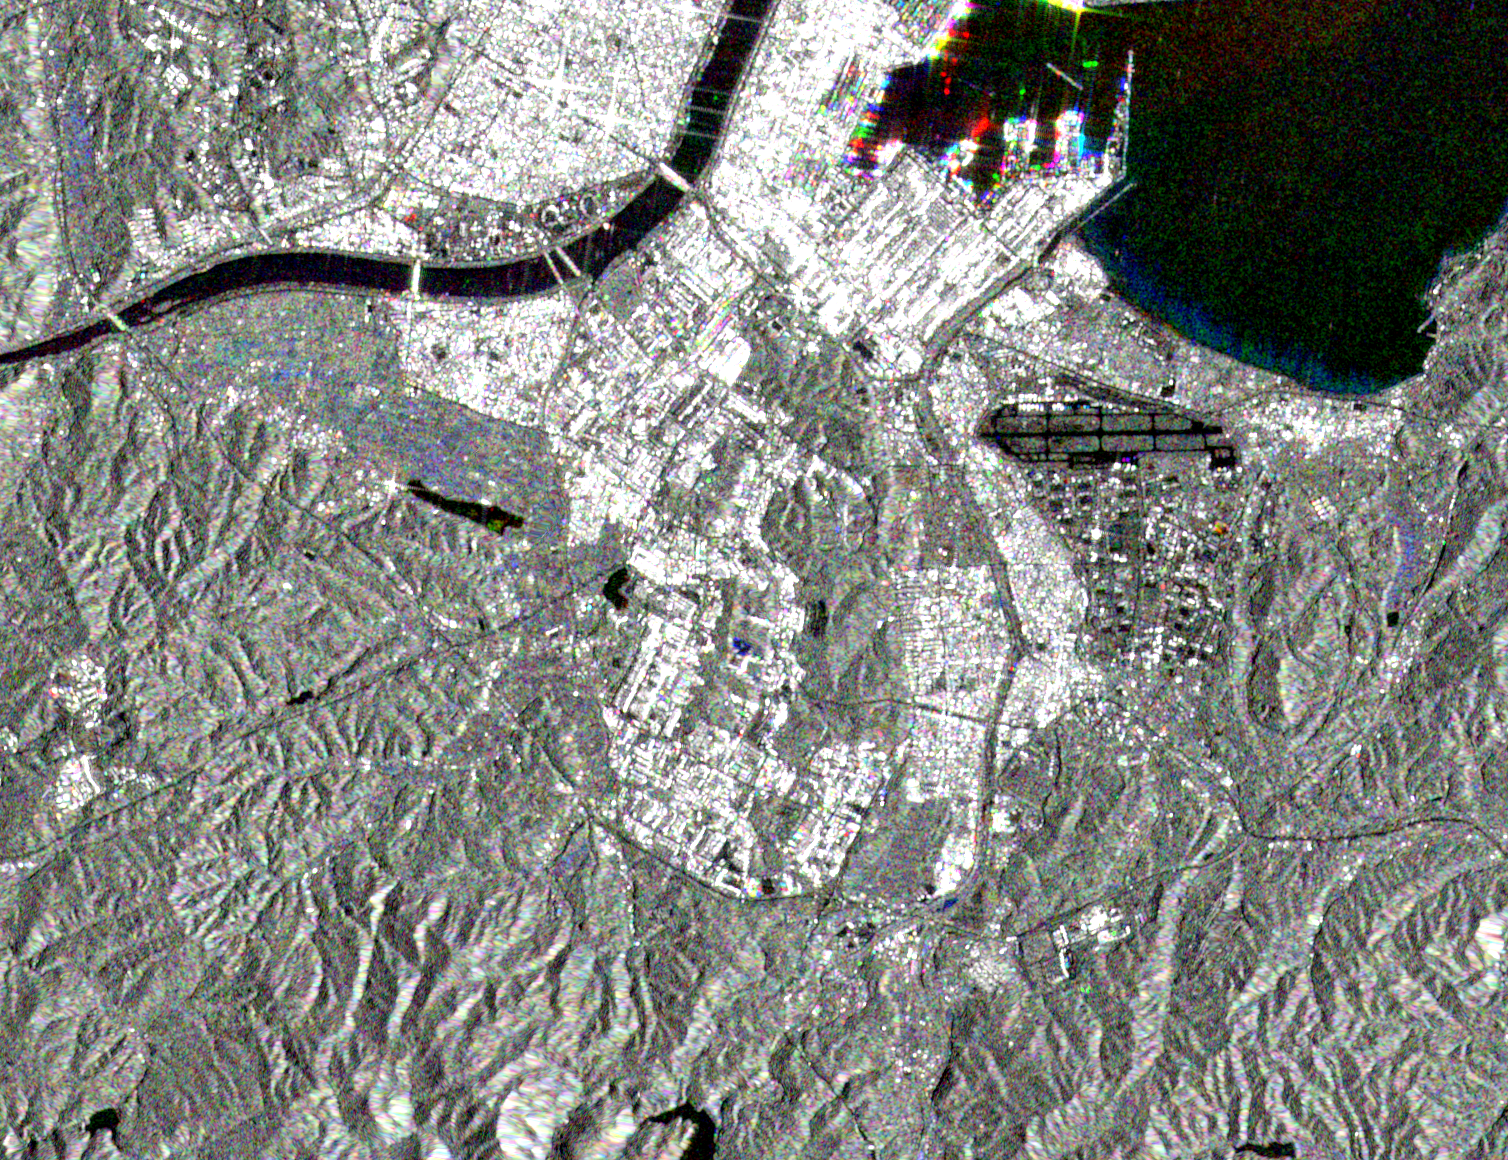

In [5]:

# Get VV band from im_list
vv_list = getvv(im_list)

# Match every img shape in vv_list
vv_list = match(vv_list)

# Stack 10,11,12 bands in vv_list
rgb_image = rgb_compostite(vv_list, [10,11,12], [-20,0], band=1)

bounds, location = folium_transform(vv_list)
mp = folium.Map(location=location, zoom_start=12)
mp.add_child(folium.raster_layers.ImageOverlay(rgb_image, bounds=bounds,
                                               opacity=1, name = 'RGB Composite'))
mp.add_child(folium.LayerControl())
# mp.save(r'/Users/hoyeong/Documents/PYTHON/ChangeDetection/CDT/RGB_Composite.html')
display(mp)


## False positive rate

In [6]:

alpha = 0.01
print('%.2f%%' %((1-(1-alpha)**len(im_list))*100))


14.85%


## Sub Image_list


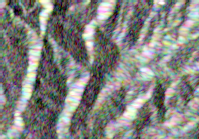

In [7]:

aoi_sub = {"coordinates": [
          [
            [
              129.33486887065214,
              35.94604676520781
            ],
            [
              129.33486887065214,
              35.933629878792274
            ],
            [
              129.35682593712005,
              35.933629878792274
            ],
            [
              129.35682593712005,
              35.94604676520781
            ],
            [
              129.33486887065214,
              35.94604676520781
            ]
          ]
        ],
        "type": "Polygon"
      }

im_list_sub = clip_img(fp, aoi_sub)
im_list_sub = match(im_list_sub)
im_list_sub = getvv(im_list_sub)
rgb_image_sub = rgb_compostite(im_list_sub, [10,11,12], [-20,0], band=1)

bounds, location = folium_transform(im_list_sub)
mp = folium.Map(location=location, zoom_start=12)
mp.add_child(folium.raster_layers.ImageOverlay(rgb_image_sub, bounds=bounds,
                                               opacity=1, name = 'RGB_SUB Composite'))
mp.add_child(folium.LayerControl())
# mp.save(r'/Users/hoyeong/Documents/PYTHON/ChangeDetection/CDT/RGB_SUB Composite.html')
display(mp)


## Histogram matching

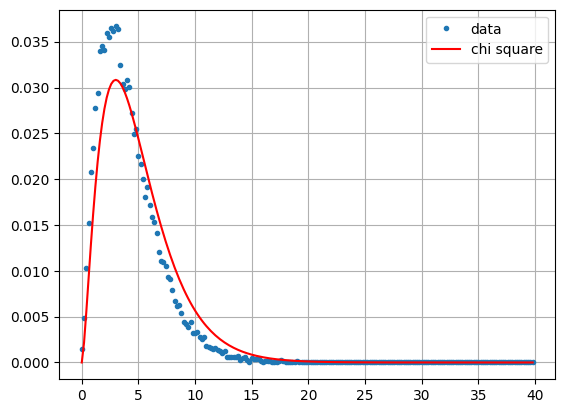

In [8]:
# There seems a slight mismatch; Some changes in aoi_sub area
k = 6
for i in range(len(im_list_sub)):
    im_list_sub[i]['band_data']['vv_band'] = interpolate_nan(im_list_sub[i]['band_data']['vv_band'])

omn = omnibus(im_list_sub[0:k])
omn = omn.flatten()

y,x = np.histogram(omn, bins = 200, range=(0,40)) 
y = y / np.sum(y) # normalize
x = x[:-1]

plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, k-1)/5, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()


## Change Map(VV band Omnibus)


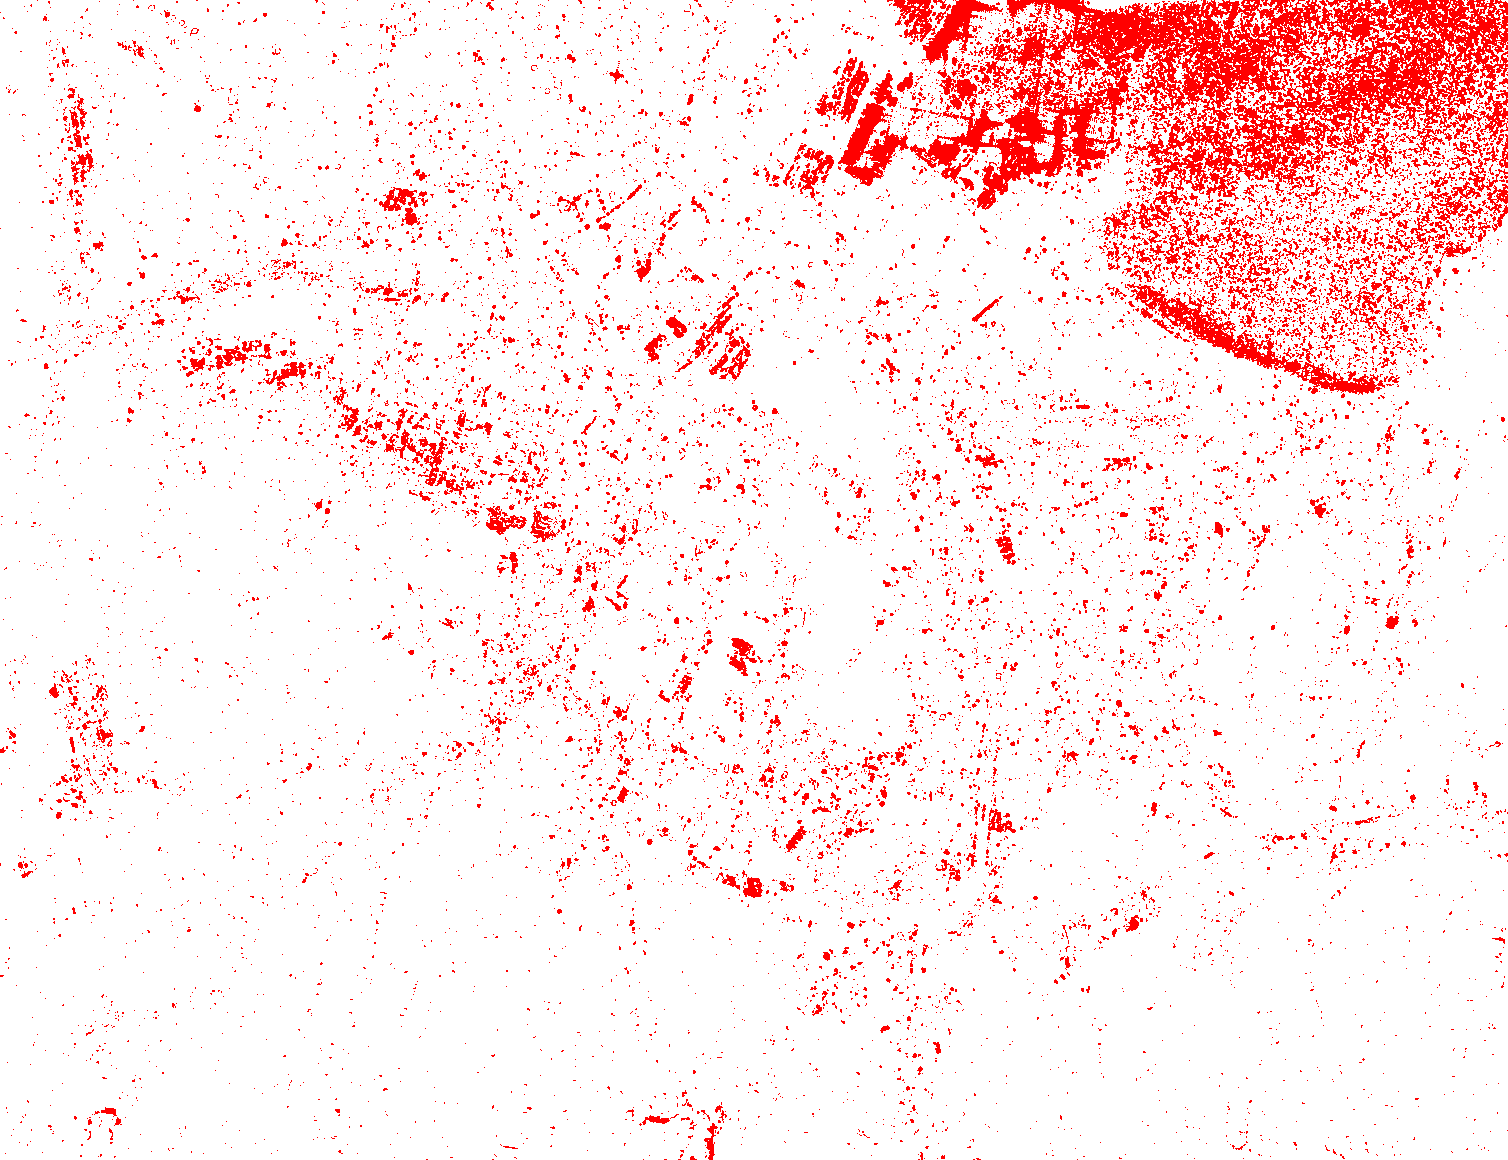

In [9]:

k = len(vv_list); alpha = 0.01

p_value = 1 - chi2.cdf(omnibus(vv_list), k-1)
c_map = (p_value < alpha).astype(int)

colors = [(0,0,0,0), 'red'] # transparent, red
cmap = ListedColormap(colors)
c_map = cmap(c_map)

bounds, location = folium_transform(vv_list)
mp = folium.Map(location=location, zoom_start=11)
mp.add_child(folium.raster_layers.ImageOverlay(c_map, bounds=bounds,
                                               opacity=1, name = 'Change Map'))
mp.add_child(folium.LayerControl())
# mp.save(r'/Users/hoyeong/Documents/PYTHON/ChangeDetection/CDT/Omnibus Change Map.html')
display(mp)


## Correlation Coefficient

In [10]:

samples = [sample_vv_imgs(j, im_list_sub) for j in range(2, 9)]
np.set_printoptions(precision=2, suppress=True)
print(np.corrcoef(samples))


[[ 1.    0.05  0.03 -0.04 -0.03 -0.05 -0.03]
 [ 0.05  1.    0.02 -0.05 -0.01  0.01  0.06]
 [ 0.03  0.02  1.    0.03 -0.07  0.    0.01]
 [-0.04 -0.05  0.03  1.   -0.01 -0.    0.07]
 [-0.03 -0.01 -0.07 -0.01  1.   -0.03 -0.01]
 [-0.05  0.01  0.   -0.   -0.03  1.   -0.02]
 [-0.03  0.06  0.01  0.07 -0.01 -0.02  1.  ]]


## Still working on Sequential omnibus test...
## Coming Soon...

In [11]:

def log_det_sum(im_list, j):
    """Returns log of determinant of the sum of the first j images in im_list."""
    sumj = {
            'band_data': {'vv_band': np.sum([img['band_data']['vv_band'] for img in im_list[0:j]]),
                          'vh_band': np.sum([img['band_data']['vh_band'] for img in im_list[0:j]])}, 
            'angle':  im_list[0]['angle'],
            'meta':   im_list[0]['meta'],
            'bounds': im_list[0]['bounds'],
            'name':   'sumj'
            }
    return np.log(det(sumj))


def log_det(im_list, j):
    """Returns log of the determinant of the jth image in im_list."""
    img = im_list[j - 1]
    return np.log(det(img))


def pval(im_list, j, m=4.4):
    """Calculates -2logRj for im_list and returns P value and -2logRj."""
    m2logRj = ((log_det_sum(im_list, j - 1) * (j - 1)
                + log_det(im_list, j)
                + 2 * j * np.log(j)
                - 2 * (j - 1) * np.log(j - 1)
                - log_det_sum(im_list, j) * j) * (-2 * m))
    pv = 1 - chi2.cdf(m2logRj, 2)
    return pv, m2logRj


def p_values(im_list):
    """Pre-calculates the P-value array for a list of images."""
    k = len(im_list)

    def ells_map(ell):
        """Arranges calculation of pval for combinations of k and j."""
        # Slice the series from k-l+1 to k (image indices start from 0).
        ell = int(ell)
        im_list_ell = im_list[k - ell: k]

        def js_map(j):
            """Applies pval calculation for combinations of k and j."""
            j = int(j)
            pv1, m2logRj1 = pval(im_list_ell, j)
            return {'pv': pv1, 'm2logRj': m2logRj1}

        # Map over j=2,3,...,l.
        js = list(range(2, ell + 1))
        pv_m2logRj = [js_map(j) for j in js]

        # Calculate m2logQl from collection of m2logRj images.
        m2logQl = np.sum([item['m2logRj'] for item in pv_m2logRj])
        pvQl = 1 - chi2.cdf(m2logQl, (ell - 1) * 2)
        pvs = [item['pv'] for item in pv_m2logRj] + [pvQl]
        return pvs

    # Map over l = k to 2.
    ells = list(range(k, 1, -1))
    pv_arr = [ells_map(ell) for ell in ells]

    # Return the P value array ell = k,...,2, j = 2,...,l.
    return pv_arr

